In [1]:
import pandas as pd


In [2]:
# read in conservative.csv and liberal.csv
cons = pd.read_csv('conservative.csv')
lib = pd.read_csv('liberal.csv')

In [3]:
# combine both with with another column with lib as 0 and cons as 1
cons['class'] = 0
lib['class'] = 1
combined = pd.concat([cons, lib], ignore_index=True)

In [5]:
combined

,Comment,class
0,I imagine the Florida Subs going to have a mel...,0
1,Good that Florida is joining the ranks. \n\nSa...,0
2,2A is pretty clear.,0
3,Every state should be Constitutional carry.......,0
4,>Florida is the 26th state with laws on the bo...,0
...,...,...
15995,I get it. I’m sure someone has convinced thems...,1
15996,its fedexed from labs in china to remailers. ...,1
15997,95ish% of smuggled drugs come through Ports of...,1
15998,china...,1


In [7]:
# use tfidf and classify with logistic regression and linear svc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# drop any nan values
combined = combined.dropna()

# split into train and test
X_train, X_test, y_train, y_test = train_test_split(combined['Comment'], combined['class'], test_size=0.2, random_state=42)

# tfidf
tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf.fit_transform(X_train)
tfidf_test = tfidf.transform(X_test)

# logistic regression
logreg = LogisticRegression()
logreg.fit(tfidf_train, y_train)
y_pred = logreg.predict(tfidf_test)
print('Logistic Regression')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))

# SVC ovr
svc = LinearSVC(multi_class='ovr')
svc.fit(tfidf_train, y_train)
y_pred = svc.predict(tfidf_test)
print('SVC')
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Confusion Matrix: ', confusion_matrix(y_test, y_pred))


Logistic Regression
Accuracy:  0.6840625
Confusion Matrix:  [[1071  533]
 [ 478 1118]]
SVC
Accuracy:  0.691875
Confusion Matrix:  [[1090  514]
 [ 472 1124]]


In [158]:
# import f1 score
from sklearn.metrics import f1_score

def trainAndPredictSVC(X_train, X_test, y_train, y_test):
    tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
    tfidf_train = tfidf.fit_transform(X_train)
    tfidf_test = tfidf.transform(X_test)

    svc = LinearSVC(multi_class='ovr')
    svc.fit(tfidf_train, y_train)
    y_pred = svc.predict(tfidf_test)
    return f1_score(y_test, y_pred, average='weighted')

trainAndPredictSVC(X_train, X_test, y_train, y_test)

SVC
Accuracy:  0.5825515947467167
Confusion Matrix:  [[ 393  790]
 [ 545 1470]]
Classification Report: 
                precision    recall  f1-score   support

           0       0.42      0.33      0.37      1183
           1       0.65      0.73      0.69      2015

    accuracy                           0.58      3198
   macro avg       0.53      0.53      0.53      3198
weighted avg       0.56      0.58      0.57      3198



In [146]:
# select a sample of 100 comments
sample = combined.sample(10)
sample

,Comment,class
10807,Honestly I don't think that's it. Desantis is much smarter than trump. I believe he recognizes that publicly acknowledging trump's dumb fucking bullshit is a way to empower him almost. What does trump hate more than anything in the world? Being ignored. \nOn that note what does desantis hate more than anything else in the world? Minorities.,1
1063,I absolutely despise content that portrays improper use of firearms. No self respecting gun owner would ever display such incompetent firearm safety skill. Respect and treat every gun like it’s loaded.,0
13398,"I find it kind of hilarious but more infuriating. They participated in an attempted coup and yet here they are. I am beside myself that the DOJ has not stopped them. It is all just too bizarre for words, isn’t it?",1
12072,Don't give Trump's name so much power. He's not freaking Voldemort.,1
6043,"17 comments, all hidden???\n\nUpdate, it's now 38 comments, with 36 of them hidden. Can someone explain this to me?",0
770,So now it’s ok to misgender them? Ugh.,0
15283,It's pretty tame compared to what people say should be done with liberals...\n\nThis double standard is ridiculous.,1
9443,These groups need to be exposed and brought down.,1
15156,They spew what they hear on Fox News. I battle with these people constantly.,1
14640,Sweet summer child. That’s adorable.,1


In [147]:
import openai 
openai.api_key = ""

def requestGPTEndpoint(prompt):
    completion = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content": "You are a classification model. Output as instructed."},
            {"role": "user", "content": prompt}
        ]
    )
    return parseGPTOutput(completion.choices[0].message.content)

def parseGPTOutput(output):
    lines = output.split("\n")
    df = pd.DataFrame(columns=["id", "chatGPT_classification"])
    for line in lines:
        if line != "":
            id, category = line.split(",")
            # use concat instead of append
            df = pd.concat([df, pd.DataFrame({"id": id.strip(), "chatGPT_classification": category.strip()}, index=[0])])
           
    df.set_index("id", inplace=True)
    return df



def callGPT(tweets, humanFlags):
    intialPrompt = "Classify the following reddit comments based on if they are taking a CONSERVATIVE (polically conservative), LIBERAL (politcally liberal) or NONE (neither) stance. Input will be in the format of: ID, <COMMENT>"
    endPrompt = "Output as: ID, <CATEGORY>"
    tokenCount = 0

    # add intialPrompt and endPrompt to the token count
    tokenCount += len(intialPrompt.split())
    tokenCount += len(endPrompt.split())
    promptTokenCount = tokenCount

    requests = []
    id = 0
    actualPrompt = intialPrompt

    for tweet in tweets:
        #print(tweet)
        tokenCount += len(tweet.split())
        actualPrompt += f"\n{id}, {tweet}"
        if tokenCount > 2048:
            actualPrompt += f"\n{endPrompt}"
            requests.append(actualPrompt)
            actualPrompt = intialPrompt
            tokenCount = promptTokenCount
        id += 1
    if tokenCount > promptTokenCount:
        actualPrompt += f"\n{endPrompt}"
        requests.append(actualPrompt)
        
    
    #print(requests)
    #print(len(requests))
    dfs = []
    for request in requests:
        dfs.append(requestGPTEndpoint(request))

    rows = []

    for idx, (classification, human_flag, tweet) in enumerate(zip(pd.concat(dfs)["chatGPT_classification"], humanFlags, tweets)):
        row_df = pd.DataFrame({"chatGPT_classification": [classification],
                               "human_classification": [human_flag],
                               "tweet": [tweet]})
        rows.append(row_df)

    result_df = pd.concat(rows, ignore_index=True)

    return result_df

classifed = callGPT(sample["Comment"], sample["class"])

In [148]:
classifed


,chatGPT_classification,human_classification,tweet
0,LIBERAL,1,Honestly I don't think that's it. Desantis is much smarter than trump. I believe he recognizes that publicly acknowledging trump's dumb fucking bullshit is a way to empower him almost. What does trump hate more than anything in the world? Being ignored. \nOn that note what does desantis hate more than anything else in the world? Minorities.
1,CONSERVATIVE,0,I absolutely despise content that portrays improper use of firearms. No self respecting gun owner would ever display such incompetent firearm safety skill. Respect and treat every gun like it’s loaded.
2,LIBERAL,1,"I find it kind of hilarious but more infuriating. They participated in an attempted coup and yet here they are. I am beside myself that the DOJ has not stopped them. It is all just too bizarre for words, isn’t it?"
3,LIBERAL,1,Don't give Trump's name so much power. He's not freaking Voldemort.
4,NONE,0,"17 comments, all hidden???\n\nUpdate, it's now 38 comments, with 36 of them hidden. Can someone explain this to me?"
5,LIBERAL,0,So now it’s ok to misgender them? Ugh.
6,CONSERVATIVE,1,It's pretty tame compared to what people say should be done with liberals...\n\nThis double standard is ridiculous.
7,LIBERAL,1,These groups need to be exposed and brought down.
8,LIBERAL,1,They spew what they hear on Fox News. I battle with these people constantly.
9,NONE,1,Sweet summer child. That’s adorable.


In [76]:
classifed.sample(10)

,chatGPT_classification,human_classification,tweet
15288,LIBERAL,1,Wait what? Balt has legal weed?
2012,CONSERVATIVE,0,"They're working together (republicans too imo) with the 3 letter orgs, CIA,NSA, FBI, CDC, WEF along with big tech and pharma. They're breaking society down in order to reduce population and instill the own nothing and be happy nwo"
15925,NONE,1,"Lolol, now you can tell them it doesn't matter how much a new battery is since most new car batteries should outlast the car anyway. Line... When will they replace their engine? Oh if you take care of it you won't have too? Ah, then they understand how batteries work lol"
2209,NONE,0,"If you find yourself agreeing with the majority, then rethink your stance/"
7213,NONE,0,"If the GOP wins in 2024, and I hope they do, they would never do this. They'll have the power to fix the mess their constituents made, and *do nothing*. That's how they operate. They say they'll fix the Democrats' mess, do nothing, then blame the Democrats for stopping them."
2570,NONE,0,New york also tryna tax Uber and food delivery to pay for public transit that only one city uses
2064,NONE,0,May I hear your interpretation of trump getting indicted? (Getting my popcorn 🍿)
15849,CONSERVATIVE,1,They love affordable housing initiatives as long as the affordable housing is far away from them.
12923,CONSERVATIVE,1,"Looks like Sweden ""found"" their get into NATO free card."
5473,CONSERVATIVE,0,Lmao! Hahahahahaha.........FIRED!


In [86]:
import numpy as np

In [245]:
# create an active learning loop
OrginalDataset = pd.read_csv('classified.csv')

# ignore the warnings
pd.options.mode.chained_assignment = None  # default='warn'

# import f1 score
from sklearn.metrics import f1_score

ConservativeScore = []
# loop for conservative score
for i in range(100):
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(OrginalDataset['tweet'], OrginalDataset['human_classification'], test_size=0.2)

    # get the confidence scores
    tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
    tfidf_train = tfidf.fit_transform(X_train)
    tfidf_test = tfidf.transform(X_test)

    svc = LinearSVC()
    svc.fit(tfidf_train, y_train)
    y_pred = svc.predict(tfidf_test)
    y_pred_prob = svc.decision_function(tfidf_test)

    # y_pred_prob is a 1d array. Get the indexes of values closest to 0 
    smallest_indexes = np.argsort(np.abs(y_pred_prob), axis=0)[:100]
    #print(smallest_indexes)

    # print f1 score
    print(f1_score(y_test, y_pred, labels = [0]))
    ConservativeScore.append(f1_score(y_test, y_pred, labels = [0]))
    
    # # print the comments with the smallest indexes
    # print(OrginalDataset.iloc[smallest_indexes])

    # for each index, if chatGPT_classification is "NONE" or "LIBERAL", set it to 1, else set it to 0
    for index in smallest_indexes:
        if OrginalDataset.iloc[index]['chatGPT_classification'] in ['NONE', 'LIBERAL']:
            OrginalDataset.at[index, 'human_classification'] = 1
        else:
            OrginalDataset.at[index, 'human_classification'] = 0

LiberalScore = []
# loop for conservative score
for i in range(100):
    # split into train and test
    X_train, X_test, y_train, y_test = train_test_split(OrginalDataset['tweet'], OrginalDataset['human_classification'], test_size=0.2)

    # get the confidence scores
    tfidf = TfidfVectorizer(stop_words='english', max_df=0.7)
    tfidf_train = tfidf.fit_transform(X_train)
    tfidf_test = tfidf.transform(X_test)

    svc = LinearSVC()
    svc.fit(tfidf_train, y_train)
    y_pred = svc.predict(tfidf_test)
    y_pred_prob = svc.decision_function(tfidf_test)

    # y_pred_prob is a 1d array. Get the indexes of values closest to 0 
    smallest_indexes = np.argsort(np.abs(y_pred_prob), axis=0)[:100]
    #print(smallest_indexes)

    # print f1 score
    print(f1_score(y_test, y_pred, labels = [1]))
    LiberalScore.append(f1_score(y_test, y_pred, labels = [1]))
    
    # # print the comments with the smallest indexes
    # print(OrginalDataset.iloc[smallest_indexes])

    # for each index, if chatGPT_classification is "NONE" or "LIBERAL", set it to 1, else set it to 0
    for index in smallest_indexes:
        if OrginalDataset.iloc[index]['chatGPT_classification'] in ['NONE', 'CONSERVATIVE']:
            OrginalDataset.at[index, 'human_classification'] = 1
        else:
            OrginalDataset.at[index, 'human_classification'] = 0
        

0.7023370233702336
0.7009925558312655
0.7004524886877828
0.6803227808814402
0.6934703748488512
0.6879518072289157
0.6961651917404129
0.7079439252336448
0.6936753133197319
0.7070119290078556
0.7005455067470571
0.6994219653179191
0.6898134863701578
0.6843023255813955
0.6963772282921219
0.7067157835080758
0.7043502355223054
0.7039012068481616
0.6956521739130435
0.693889045339341
0.7035484772282761
0.714246947082768
0.7026875699888018
0.6949105914718019
0.694081689358155
0.7090264521407146
0.7074904319300163
0.696492681579674
0.7029490616621985
0.7152138603140228
0.7131324004305706
0.7193973634651599
0.7143617021276596
0.7145547484530536
0.7090283293619275
0.7161028416779432
0.710574652322225
0.7051899411449972
0.7044426709231179
0.7337461300309597
0.7287470572848549
0.7102212855637514
0.7124372854502243
0.7298136645962733
0.7195438050803525
0.7251431546069756
0.7168255604225714
0.7257603327268001
0.7189542483660131
0.7220805711371749
0.713552361396304
0.7237354085603113
0.7183863460046547

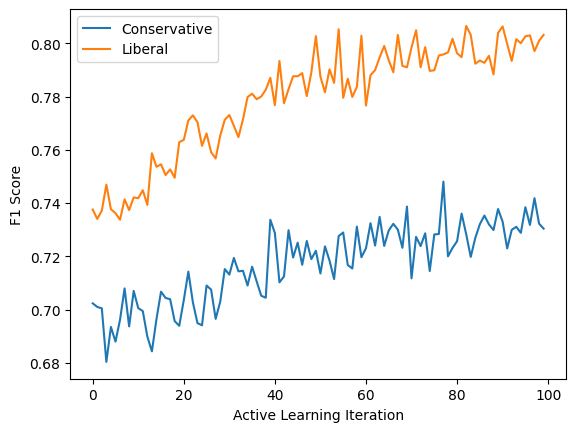

In [258]:
# plot the scores
import matplotlib.pyplot as plt
plt.plot(ConservativeScore)
plt.plot(LiberalScore)
plt.xlabel('Active Learning Iteration')
plt.ylabel('F1 Score')
# create legend
plt.legend(["Conservative", "Liberal"])

In [259]:
OrginalDataset = pd.read_csv('classified.csv')

In [261]:
# remove any rows that have a chatGPT_classification of NONE
OrginalDataset = OrginalDataset[OrginalDataset['chatGPT_classification'] != 'NONE']

# Rename the human_classification column to Subreddit
OrginalDataset = OrginalDataset.rename(columns={'human_classification': 'Subreddit'})

# change the subreddit rows where 0 to r/conservative
OrginalDataset.loc[OrginalDataset['Subreddit'] == 0, 'Subreddit'] = 'r/conservative'

# cahnge the subreddit rows where 1 to r/liberal
OrginalDataset.loc[OrginalDataset['Subreddit'] == 1, 'Subreddit'] = 'r/liberal'

# drop "Unamed: 0" column
OrginalDataset = OrginalDataset.drop(columns=['Unnamed: 0'])

# Reset index
OrginalDataset = OrginalDataset.reset_index(drop=True)

# save the dataset
OrginalDataset.to_csv('filteredOpinions.csv', index=False)

In [263]:
# shuffle the dataset
OrginalDataset = OrginalDataset.sample(frac=1).reset_index(drop=True)



In [265]:
OrginalDataset.to_csv('filteredOpinions.csv', index=False)